<a href="https://colab.research.google.com/github/ambideXtrous9/Knowledge-Distillation-using-FlanT5-Teacher-Student-Method/blob/main/Transformer_with_Beam_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet transformers
!pip install --quiet pytorch-lightning
!pip install --quiet lightning

In [2]:
import math
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import pandas as pd
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torchmetrics.functional import accuracy
from torchmetrics.classification import Accuracy
from torch.optim import AdamW
from transformers import (AutoTokenizer, AutoModelForSeq2SeqLM)
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pytorch_lightning.callbacks import RichProgressBar,ModelCheckpoint
import torch.nn.functional as F

In [3]:
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

In [4]:
url = 'https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary.csv'

In [5]:
df = pd.read_csv(url,encoding='latin')
df.head(3)

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4514 entries, 0 to 4513
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author     4514 non-null   object
 1   date       4514 non-null   object
 2   headlines  4514 non-null   object
 3   read_more  4514 non-null   object
 4   text       4514 non-null   object
 5   ctext      4396 non-null   object
dtypes: object(6)
memory usage: 211.7+ KB


In [7]:
df.columns

Index(['author', 'date', 'headlines', 'read_more', 'text', 'ctext'], dtype='object')

In [8]:
df["ctext"] = df["ctext"].astype(str)
df["text"] = df["text"].astype(str)

In [9]:
df = df[["text","ctext"]]
df.head(3)

,text,ctext
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...


In [10]:
df.columns = ["summary", "text"]
df = df.dropna()
df.head()

,summary,text
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [11]:
SRC = 'text'
TGT = 'summary'

In [12]:

# Tokenizer

tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']


# Create a vocabulary using all the text in the three columns
# Function to yield tokens from the text data
def yield_tokens(text_data):
    for text in text_data:
        yield tokenizer(text)

SRC = 'text'
TGT = 'summary'
vocab = {}

for ln in [SRC, TGT]:
    # Build a vocabulary from the iterator
    vocab[ln] = build_vocab_from_iterator(yield_tokens(df[ln]),
                                  min_freq=1,
                                  specials=special_symbols,
                                  special_first=True
                                  )

for ln in [SRC, TGT]:
    vocab[ln].set_default_index(UNK_IDX)

In [13]:
src_vocab_size = len(vocab[SRC])
print("Vocabulary Size:", src_vocab_size)

Vocabulary Size: 72216


In [14]:
tgt_vocab_size = len(vocab[TGT])
print("Vocabulary Size:", tgt_vocab_size)

Vocabulary Size: 22331


In [15]:
sentence = "What is your name?"
tokenized_sentence =  tokenizer(sentence)
indexed_sentence = [vocab[SRC][token] for token in tokenized_sentence]

print("Original Sentence:", sentence)
print("Tokenized Sentence:", tokenized_sentence)
print("Indexed Sentence:", indexed_sentence)

Original Sentence: What is your name?
Tokenized Sentence: ['What', 'is', 'your', 'name', '?']
Indexed Sentence: [673, 16, 280, 386, 12]


In [16]:
tokens = [vocab[SRC].get_itos()[i] for i in indexed_sentence]

# Join tokens to form a sentence
sentence = ' '.join(tokens)

print(sentence)

What is your name ?


In [17]:
def preprocess_sentence(sentence,vocab,label,max_length):
    # Tokenize the sentence
    tokenized_sentence = tokenizer(sentence)

    # Convert tokens to indices using the vocabulary
    indexed_sentence = [vocab[label][token] for token in tokenized_sentence]

    # Pad the sequence to the specified max_length
    padded_sentence = indexed_sentence + [vocab[label]['<pad>']] * (max_length - len(indexed_sentence))

    return padded_sentence[:max_length]  # Trim to max_length if needed


In [18]:

# Example usage:
max_length = 10  # Specify the desired maximum length
sentence = "This is an example sentence."

indexed_sentence = preprocess_sentence(sentence, vocab,SRC, max_length)
print(indexed_sentence)


[132, 16, 42, 1992, 2164, 6, 1, 1, 1, 1]


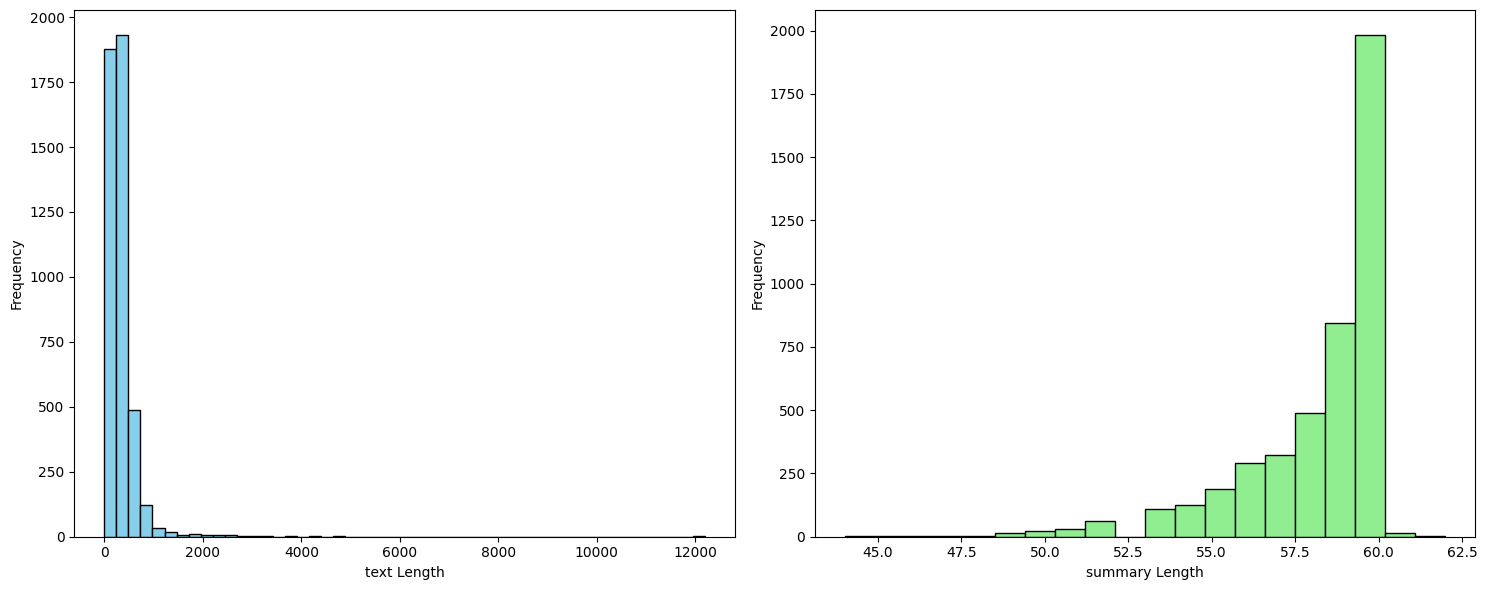

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].hist(df['text'].apply(lambda x: len(x.split())), bins=50, edgecolor='k', color='skyblue')
axes[0].set_xlabel('text Length')
axes[0].set_ylabel('Frequency')

axes[1].hist(df['summary'].apply(lambda x: len(x.split())), bins=20, edgecolor='k', color='lightgreen')
axes[1].set_xlabel('summary Length')
axes[1].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

In [20]:
# df = df.iloc[:5000]

In [21]:
class NQADataset(Dataset):
    def __init__(self,data ,vocab,source_max_token_len : int = 10,
                 target_max_token_len : int = 10):

        self.vocab = vocab
        self.data = data
        self.source_max_token_len = source_max_token_len
        self.target_max_token_len = target_max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self,index : int):
        data_row = self.data.iloc[index]

        source_encoding = preprocess_sentence(
            data_row['text'],
            vocab=vocab,
            label=SRC,
            max_length = self.source_max_token_len)

        target_encoding = preprocess_sentence(
            data_row['summary'],
            vocab=vocab,
            label=TGT,
            max_length = self.target_max_token_len)

        source_encoding = torch.tensor(source_encoding)
        target_encoding = torch.tensor(target_encoding)

        return dict(
            input_ids = source_encoding,
            labels = target_encoding)


In [22]:

class NQADataModule(pl.LightningDataModule):
  def __init__(self,train_df,val_df,vocab,batch_size : int = 8,
               source_max_token_len : int = 10,target_max_token_len : int = 10):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.val_df = val_df
    self.vocab = vocab
    self.source_max_token_len = source_max_token_len
    self.target_max_token_len = target_max_token_len

  def setup(self,stage=None):
    self.train_dataset = NQADataset(self.train_df,self.vocab,self.source_max_token_len,self.target_max_token_len)
    self.val_dataset = NQADataset(self.val_df,self.vocab,self.source_max_token_len,self.target_max_token_len)


  def train_dataloader(self):
    return DataLoader(self.train_dataset,batch_size = self.batch_size,shuffle=True,num_workers=4)

  def val_dataloader(self):
    return DataLoader(self.val_dataset,batch_size = self.batch_size,num_workers=4)


In [23]:
train_df, val_df = train_test_split(df,test_size=0.1)

In [24]:
print(train_df.shape)
print(val_df.shape)

(4062, 2)
(452, 2)


In [25]:
data_module = NQADataModule(train_df,val_df,vocab=vocab,batch_size = 32)
data_module.setup()

In [26]:
sample_batch = next(iter(data_module.val_dataloader()))
for key, value in sample_batch.items():
    print(f"{key}: {value.shape}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


input_ids: torch.Size([32, 10])
labels: torch.Size([32, 10])


In [27]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Model

![](https://media.arxiv-vanity.com/render-output/3715543/Figures/ModalNet-21.png)

In [28]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])


In [29]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


In [30]:
def generate_square_subsequent_mask(size: int):
    """Generate a triangular (size, size) mask. From PyTorch docs."""
    mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [31]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [32]:
def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [33]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = nn.Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

        self.sftmx = nn.Softmax()
        self.lgsftmx = nn.LogSoftmax()

    def forward(self,
                src ,
                trg ,
                src_mask,
                tgt_mask,
                src_padding_mask,
                tgt_padding_mask,
                memory_key_padding_mask):

        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))

        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask,
                                memory_key_padding_mask)

        return self.generator(outs)

    def encode(self, src, src_mask):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)),
                            src_mask)

    def decode(self, tgt, memory, tgt_mask):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)),
                          memory,tgt_mask)

    def predict(self, src, src_mask,max_len=10):

        memory = self.encode(src, src_mask)


        output_tokens = (torch.ones((src.shape[1], max_len))).type_as(src.permute(1,0)).long() # (B, max_length)
        output_tokens[:, 0] = 0  # Set start token


        for Sy in range(1, max_len):


            y = output_tokens[:, :Sy]  # (B, Sy)
            tgt_mask = (generate_square_subsequent_mask(y.size(1)).type(torch.bool)).to(DEVICE)

            output = self.decode(y.permute(1,0), memory,tgt_mask)  # (Sy, B, C)
            output = self.generator(output)
            output = torch.argmax(output, dim=-1)  # (Sy, B)
            output_tokens[:, Sy] = output[-1:]  # Set the last output token

        return output_tokens



In [34]:

class LitModel(pl.LightningModule):
    """Simple PyTorch-Lightning model to train our Transformer."""

    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
        self.criterion = nn.NLLLoss(ignore_index=PAD_IDX)
        self.softmax = nn.Softmax()
        self.log_softmax = nn.LogSoftmax()

        self.valloss = []
        self.valacc = []
        self.avgloss = []


    def training_step(self, batch, batch_ind):
        src = batch['input_ids'].permute(1, 0)
        tgt = batch['labels'].permute(1, 0)


        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt[:-1, :])

        # Teacher forcing: model gets input up to the last character,
        # while ground truth (loss is calculated) is from the second character onward.
        # logits = self.model(x, y[:, :-1])
        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = self.model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = self.loss(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_ind):
        src = batch['input_ids'].permute(1, 0)
        tgt = batch['labels'].permute(1, 0)

        # Teacher forcing: model gets input up to the last character,
        # while ground truth (loss is calculated) is from the second character onward.
        # logits = self.model(x, y[:, :-1])
        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = self.model(src, tgt_input, src_mask,
                            tgt_mask,src_padding_mask,
                            tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = self.loss(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))

        pred = self.model.predict(src,src_mask,max_len=10)

        correct_predictions = (tgt.permute(1,0) == pred).float()
        row_accuracies = torch.mean(correct_predictions, dim=1)
        accuracy = torch.mean(row_accuracies).item()


        self.log_dict({"val_acc" : accuracy,
                       "val_loss" : loss,
                       },on_step=False, on_epoch=True, prog_bar=True)

        self.valloss.append(loss.item())
        self.valacc.append(accuracy)

    def on_validation_epoch_end(self):

        avg_val_loss = torch.mean(torch.tensor(self.valloss))
        avg_val_acc = torch.mean(torch.tensor(self.valacc))

        self.avgloss.append(avg_val_loss)

        self.valacc.clear()
        self.valloss.clear()

        print('-' * 90)
        print(f'|  Epoch = {self.current_epoch + 1:3d} | '
            f'Average Validation Loss: {avg_val_loss.item():5.2f} | '
            f'Average Validation Accuracy: {avg_val_acc.item():5.2f} |')
        print('-' * 90)

        temploss = self.avgloss
        avgloss_np = np.array(temploss)

        # Create x-axis values as the length of avgloss
        x_values = list(range(1, len(avgloss_np) + 1))

        # Plotting
        plt.plot(x_values, avgloss_np, marker='o')
        plt.xlabel('Length of avgloss')
        plt.ylabel('Average Validation Loss')
        plt.title('Average Validation Loss vs Length of avgloss')
        plt.show()



    def configure_optimizers(self):
        return AdamW(self.parameters(),lr = 2e-6)

In [35]:
from lightning.pytorch.loggers import TensorBoardLogger

logger = TensorBoardLogger("tb_logs", name="my_model")

In [36]:
rpb = RichProgressBar()

In [37]:
trainer = pl.Trainer(accelerator="gpu",
                     devices=-1,
                     callbacks=[rpb],
                     max_epochs = 20)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [38]:
SRC_VOCAB_SIZE = src_vocab_size
TGT_VOCAB_SIZE = tgt_vocab_size
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 256
BATCH_SIZE = 8
NUM_ENCODER_LAYERS = 6
NUM_DECODER_LAYERS = 6

In [39]:
model = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)
lit_model = LitModel(model)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name        ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model       │ Seq2SeqTransformer │ 82.0 M │
│ 1 │ loss        │ CrossEntropyLoss   │      0 │
│ 2 │ criterion   │ NLLLoss            │      0 │
│ 3 │ softmax     │ Softmax            │      0 │
│ 4 │ log_softmax │ LogSoftmax         │      0 │
└───┴─────────────┴────────────────────┴────────┘

Trainable params: 82.0 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 82.0 M                                                                                               
Total estimated model params size (MB): 327

Output()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will 
create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller 
than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader 
running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched 
key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(

------------------------------------------------------------------------------------------

|  Epoch =   1 | Average Validation Loss: 10.19 | Average Validation Accuracy:  0.00 |

------------------------------------------------------------------------------------------

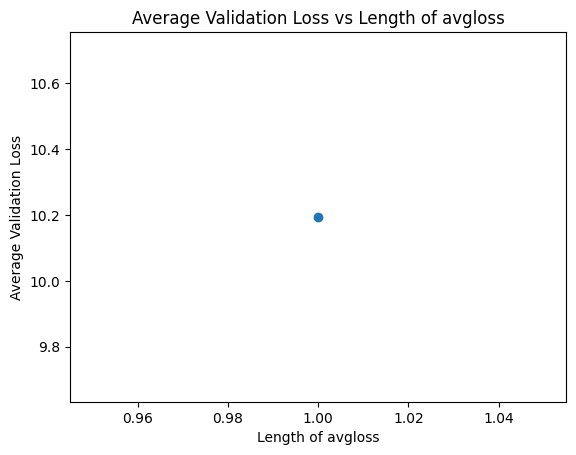

------------------------------------------------------------------------------------------

|  Epoch =   1 | Average Validation Loss:  9.51 | Average Validation Accuracy:  0.02 |

------------------------------------------------------------------------------------------

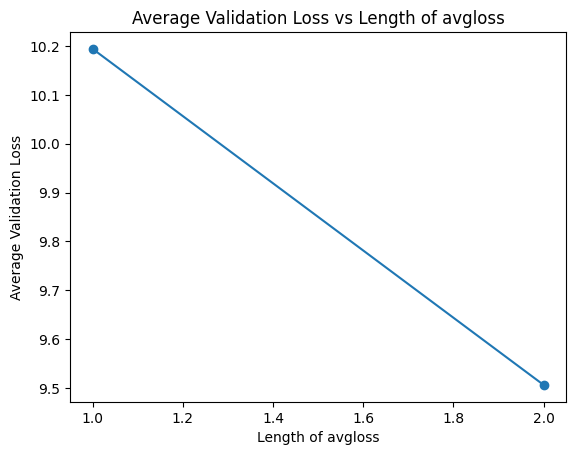

------------------------------------------------------------------------------------------

|  Epoch =   2 | Average Validation Loss:  9.20 | Average Validation Accuracy:  0.02 |

------------------------------------------------------------------------------------------

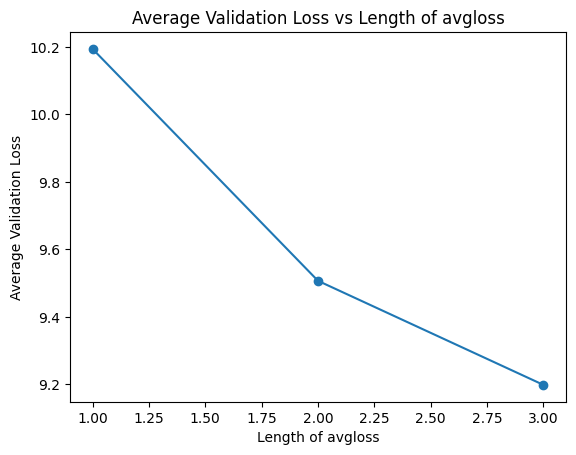

------------------------------------------------------------------------------------------

|  Epoch =   3 | Average Validation Loss:  9.01 | Average Validation Accuracy:  0.02 |

------------------------------------------------------------------------------------------

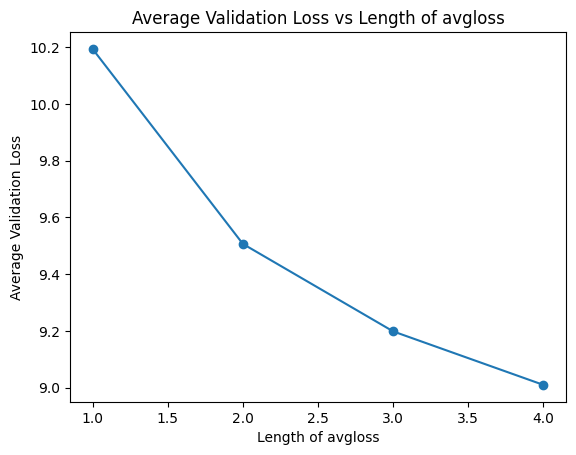

------------------------------------------------------------------------------------------

|  Epoch =   4 | Average Validation Loss:  8.87 | Average Validation Accuracy:  0.02 |

------------------------------------------------------------------------------------------

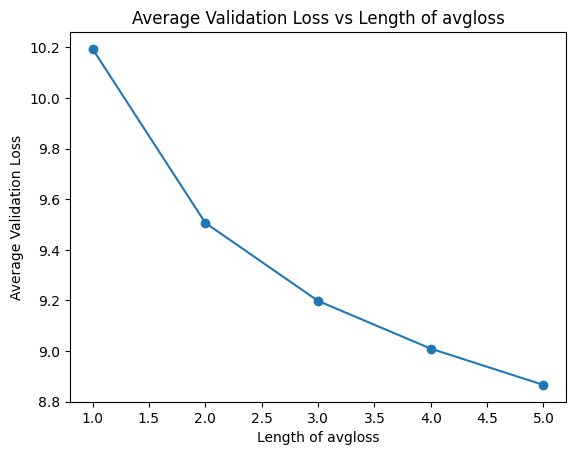

------------------------------------------------------------------------------------------

|  Epoch =   5 | Average Validation Loss:  8.75 | Average Validation Accuracy:  0.02 |

------------------------------------------------------------------------------------------

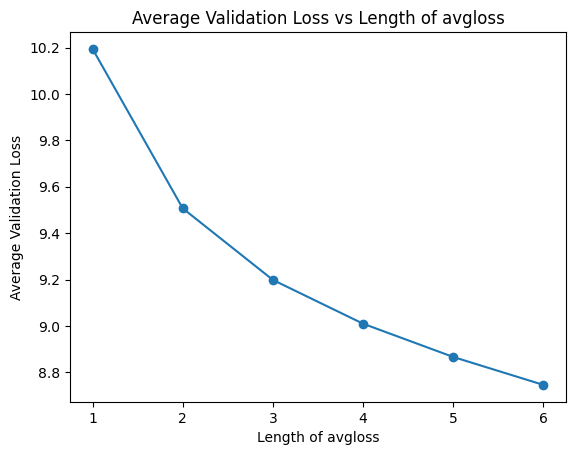

------------------------------------------------------------------------------------------

|  Epoch =   6 | Average Validation Loss:  8.64 | Average Validation Accuracy:  0.03 |

------------------------------------------------------------------------------------------

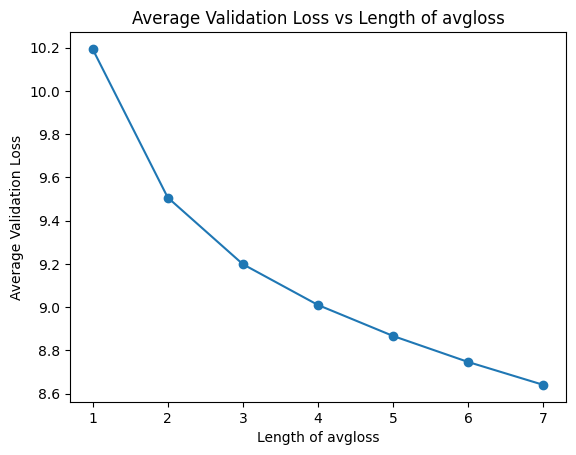

------------------------------------------------------------------------------------------

|  Epoch =   7 | Average Validation Loss:  8.54 | Average Validation Accuracy:  0.02 |

------------------------------------------------------------------------------------------

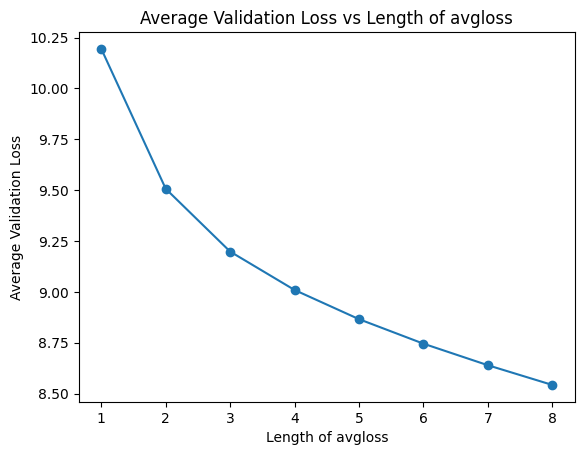

------------------------------------------------------------------------------------------

|  Epoch =   8 | Average Validation Loss:  8.46 | Average Validation Accuracy:  0.02 |

------------------------------------------------------------------------------------------

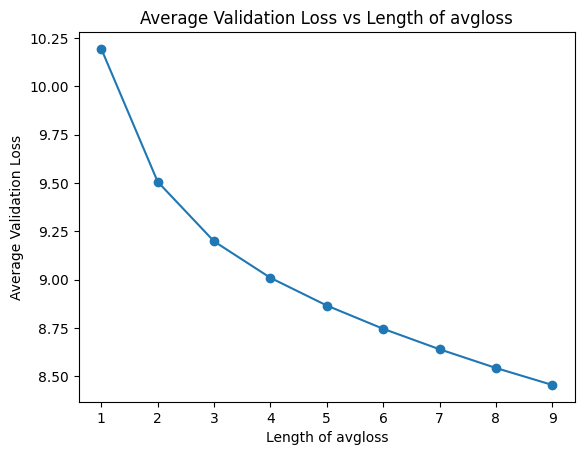

------------------------------------------------------------------------------------------

|  Epoch =   9 | Average Validation Loss:  8.37 | Average Validation Accuracy:  0.03 |

------------------------------------------------------------------------------------------

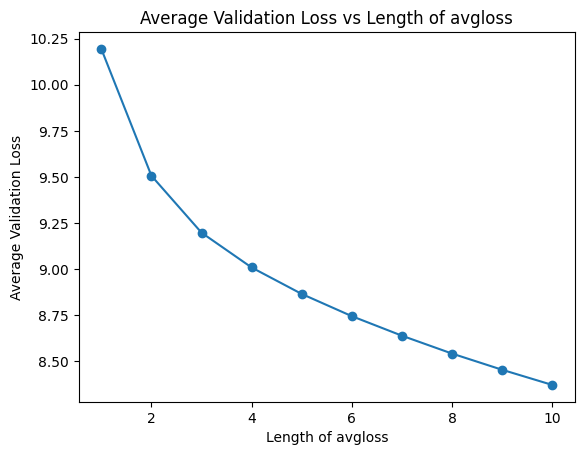

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, 
attempting graceful shutdown...

In [40]:
trainer.fit(lit_model, data_module)

In [41]:
model = model.to('cpu')


In [42]:
val_df.iloc[2]

summary    Pakistan on Saturday accused India of targetin...
text       Pakistan?s top military officer on Saturday ac...
Name: 2321, dtype: object

In [43]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long)
    for i in range(max_len-1):

        tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool))

        out = model.decode(ys, memory,tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        next_word = torch.argmax(prob, dim=-1)
        next_word = next_word.item()

        ys = torch.cat([ys,torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)

        if next_word == EOS_IDX:
            break
    return ys

In [44]:
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = torch.tensor(preprocess_sentence(src_sentence, vocab,SRC, max_length=10)).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 10, start_symbol=BOS_IDX).flatten()

    tokens = [vocab[TGT].get_itos()[i] for i in tgt_tokens]

    # Join tokens to form a sentence
    sentence = ' '.join(tokens)

    print(sentence)


In [45]:

def predict(idx):
    src = val_df.iloc[idx]['text']

    print(f"\n\nACTUAL : {val_df.iloc[idx]['summary']}\n\n")

    translate(model=model,src_sentence=src)


In [46]:
predict(6)



ACTUAL : Nineteen international and domestic flights to and from Chennai were delayed on Friday as dense smoke engulfed the area around the airport after old articles were burnt on the occasion of Bhogi. Old and unwanted articles of the past year are burnt as a symbolic gesture during Bhogi, which is celebrated on the first day of Pongal. 


<bos> has has has has has has has has has has has has has has has has has has has


In [47]:
def sequence_length_penalty(length: int, alpha: float=0.6) -> float:
    return ((5 + length) / (5 + 1)) ** alpha

In [48]:
import torch
from torch import Tensor

# Beam size and penalty alpha
beam_size = 5
alpha = 0.2

src_sentence = val_df.iloc[1]['text']

src = torch.tensor(preprocess_sentence(src_sentence, vocab,SRC, max_length=250)).view(-1, 1)
num_tokens = src.shape[0]
src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
# Generate encoded features
model.eval()
with torch.no_grad():
    encoder_output = model.encode(src,src_mask)

# Start with SOS
decoder_input = torch.Tensor([[BOS_IDX]]).long()

# Maximum output size
max_output_length = src.shape[-1] + 10 # give some extra length

scores = torch.Tensor([0.])

vocab_size = tgt_vocab_size

for i in range(max_output_length):
    # Decoder prediction

    tgt_mask = (generate_square_subsequent_mask(decoder_input.size(0))
                    .type(torch.bool)).to(DEVICE)

    logits = model.decode(decoder_input,encoder_output,tgt_mask).transpose(0, 1)


    logits = logits[:, -1]

    logit_fc = model.generator(logits)

    print("logits_fc= ",logit_fc.shape)



    # Softmax
    log_probs = torch.log_softmax(logit_fc, dim=1)
    log_probs = log_probs / sequence_length_penalty(i+1, alpha)

    decoder_input = decoder_input.permute(1,0)
    # Set score to zero where EOS has been reached
    log_probs[decoder_input[:, -1]==EOS_IDX, :] = 0




    # scores [beam_size, 1], log_probs [beam_size, vocab_size]
    scores = scores.unsqueeze(1) + log_probs



    # Flatten scores from [beams, vocab_size] to [beams * vocab_size] to get top k,
    # and reconstruct beam indices and token indices
    scores, indices = torch.topk(scores.reshape(-1), beam_size)
    beam_indices  = torch.divide(indices, vocab_size, rounding_mode='floor') # indices // vocab_size
    token_indices = torch.remainder(indices, vocab_size)                        # indices %  vocab_size

    # Build the next decoder input
    next_decoder_input = []
    for beam_index, token_index in zip(beam_indices, token_indices):
        prev_decoder_input = decoder_input[beam_index]
        if prev_decoder_input[-1]==EOS_IDX:
            token_index = EOS_IDX # once EOS, always EOS
        token_index = torch.LongTensor([token_index])
        next_decoder_input.append(torch.cat([prev_decoder_input, token_index]))
    decoder_input = torch.vstack(next_decoder_input)



    # If all beams are finished, exit
    if (decoder_input[:, -1]==EOS_IDX).sum() == beam_size:
        break


    # Encoder output expansion from the second time step to the beam size
    if i==0:
        encoder_output = encoder_output.permute(1,0,2)
        encoder_output = encoder_output.expand(beam_size, *encoder_output.shape[1:]).permute(1,0,2)


    decoder_input = decoder_input.permute(1,0)


# convert the top scored sequence to a list of text tokens
decoder_output, _ = max(zip(decoder_input, scores), key=lambda x: x[1])
print(scores)
decoder_output = decoder_output[1:].numpy() # remove SOS

output_text_tokens = [vocab[TGT].get_itos()[i] for i in decoder_output if i != EOS_IDX] # remove EOS if exists

logits_fc=  torch.Size([1, 22331])
logits_fc=  torch.Size([5, 22331])
logits_fc=  torch.Size([5, 22331])
logits_fc=  torch.Size([5, 22331])
logits_fc=  torch.Size([5, 22331])
logits_fc=  torch.Size([5, 22331])
logits_fc=  torch.Size([5, 22331])
logits_fc=  torch.Size([5, 22331])
logits_fc=  torch.Size([5, 22331])
logits_fc=  torch.Size([5, 22331])
logits_fc=  torch.Size([5, 22331])
tensor([-40.3953, -40.4227, -40.4228, -40.4272, -40.4415],
       grad_fn=<TopkBackward0>)


In [49]:
output_text_tokens

['<bos>', '<bos>', '<bos>', '<bos>']

In [50]:
def beam_search(k=10,idx=0):
    src_sentence = val_df.iloc[idx]['text']

    src = torch.tensor(preprocess_sentence(src_sentence, vocab,SRC, max_length=10)).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    # Generate encoded features
    model.eval()
    with torch.no_grad():
        encoder_output = model.encode(src,src_mask)

    # Start with SOS
    tgt = "<bos>"
    tgt = torch.tensor(preprocess_sentence(tgt, vocab,TGT, max_length=10)).view(-1, 1)

    src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt)


    prediction = model.decode(tgt,encoder_output,tgt_mask).transpose(0, 1)



    prediction = model.generator(prediction)

    batch_size, seq_length, vocab_size = prediction.shape

    log_prob, indices = prediction[:, 0, :].topk(k, sorted=True)
    indices = indices.unsqueeze(-1)

    for n1 in range(1, seq_length):
        log_prob_temp = log_prob.unsqueeze(-1) + prediction[:, n1, :].unsqueeze(1).repeat(1, k, 1)
        log_prob, index_temp = log_prob_temp.view(batch_size, -1).topk(k, sorted=True)
        idx_begin = index_temp // vocab_size  # retrieve index of start sequence
        idx_concat = index_temp % vocab_size  # retrieve index of new token
        new_indices = torch.zeros((batch_size, k, n1+1), dtype=torch.int64)
        for n2 in range(batch_size):
            new_indices[n2, :, :-1] = indices[n2][idx_begin[n2]]
            new_indices[n2, :, -1] = idx_concat[n2]
        indices = new_indices
    return indices, log_prob

In [51]:
S = beam_search(k=3,idx=55)

In [52]:
S

(tensor([[[ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
          [ 4,  4,  4, 17,  4,  4,  4,  4,  4,  4],
          [ 4,  4,  4,  4, 17,  4,  4,  4,  4,  4]]]),
 tensor([[56.9680, 56.7036, 56.7002]], grad_fn=<TopkBackward0>))

In [53]:
S[0].squeeze(0)[2]

tensor([ 4,  4,  4,  4, 17,  4,  4,  4,  4,  4])

In [54]:
indexed_sentence = S[0].squeeze(0)[0]

In [55]:
tokens = [vocab[SRC].get_itos()[i] for i in indexed_sentence]

# Join tokens to form a sentence
sentence = ' '.join(tokens)

print(sentence)

the the the the the the the the the the
